In [5]:
import cupy as cp
import numpy as np

from plot import points as plot_points
from utils import read_coo_array

In [54]:
print("CuPy Custom Kernel Example")
print(f"GPU ID: {cp.cuda.Device().id}")

G = read_coo_array("fss-1e5.arrow")
assert G.shape[0] == G.shape[1]

CuPy Custom Kernel Example
GPU ID: 0


In [49]:
from is_symmetric import is_symmetric_coo

# print("checking that G is symmetric")
# assert is_symmetric_coo(G)

print("eliminating lower triangle")
mask = G.row <= G.col  # Upper triangle only
G.row, G.col, G.data = (
    G.row[mask],
    G.col[mask],
    G.data[mask],
)

eliminating lower triangle


In [55]:
sources = cp.asarray(G.row, dtype=cp.int32)
targets = cp.asarray(G.col, dtype=cp.int32)
weights = cp.asarray(G.data, dtype=cp.float32)
assert sources.shape == targets.shape

n_nodes = G.shape[0]
n_edges = len(weights)

print(f"n_nodes: {n_nodes}, n_edges: {n_edges}")
print('sources', sources)
print('targets', targets)

n_nodes: 100000, n_edges: 1502260
sources [    0     0     0 ... 99999 99999 99999]
targets [13811 13831 13832 ... 99261 99276 99472]


initial_pos: [[3.74540119 5.80779043]
 [9.50714306 5.2697165 ]
 [7.31993942 3.5103695 ]
 ...
 [6.74453407 1.92203677]
 [4.99447245 6.5308269 ]
 [3.89908485 0.01560081]]
9.99992042302966 9.999893848262147
5.536675737993768e-05 4.778609163147429e-05


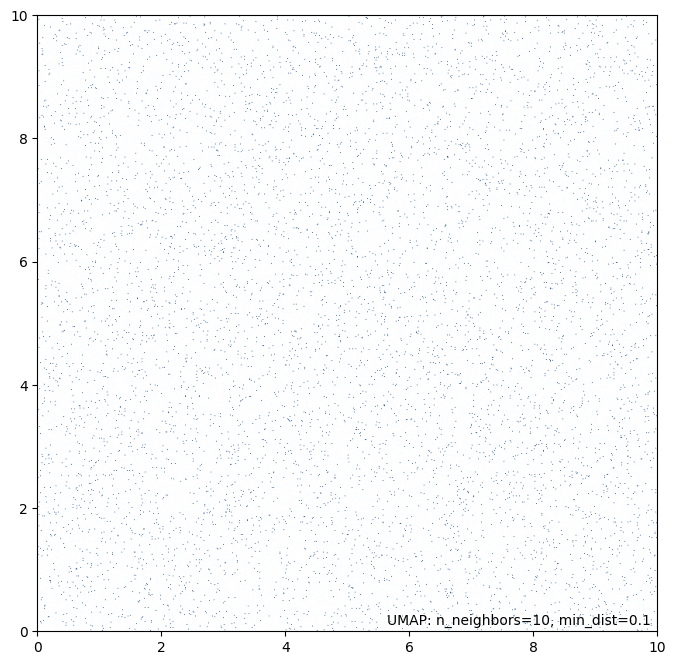

In [56]:
rand = np.random.RandomState(42)
initial_pos = np.column_stack((rand.random(n_nodes), rand.random(n_nodes)))
initial_pos *= 10
print("initial_pos:", initial_pos)
plot_points(initial_pos, n_neighbors=10, min_dist=0.1)
print(np.max(initial_pos[:, 0]), np.max(initial_pos[:, 1]))
print(np.min(initial_pos[:, 0]), np.min(initial_pos[:, 1]))

Sampling 1,502,260 edges using custom kernel...
Grid: 46946 blocks × 32 threads
[213  77 188 ...   0   0   0] 48
sources [    0     0     0 ... 99999 99999 99999]
targets [13811 13831 13832 ... 99261 99276 99472]


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1437.66it/s]

final_pos [[ 1.7977276  5.7876506]
 [ 2.794578   6.444255 ]
 [ 2.141289   5.920841 ]
 ...
 [ 1.0687969  6.8720684]
 [-8.003091  -2.5361547]
 [-3.8445559 -1.1709436]]


<Axes: >

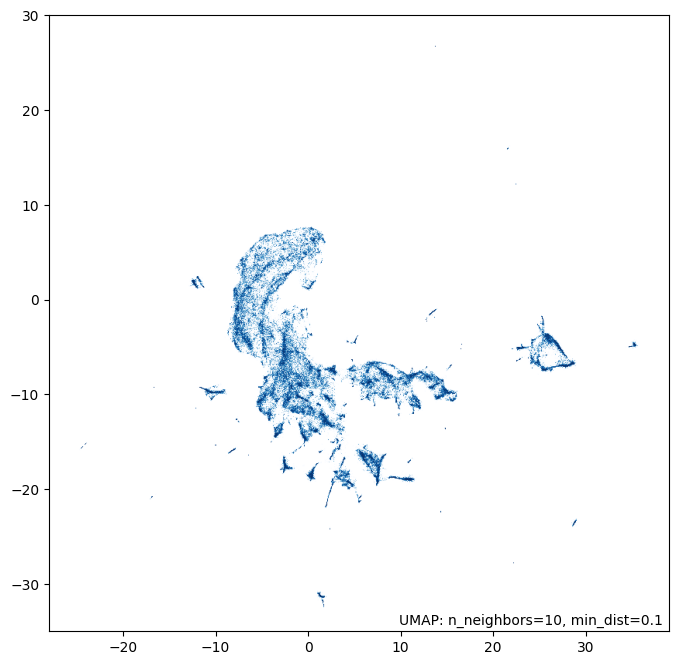

In [58]:
import importlib
import layout_cuda

importlib.reload(layout_cuda)

final_pos = layout_cuda.layout(sources, targets, weights, initial_pos, n_epochs=10000)
print("final_pos", final_pos)
plot_points(final_pos, n_neighbors=10, min_dist=0.1)